# 数据结构
每一个entity代表一个combination, 一个combination包含2个pair, 每个pair是trait--Condition格式. 这些pairs都是有重合基因, 并且通过了hypergeometric test的, 存储在fdr_adj_pval列.

# Research Plan Aim 1.4 内容
之前我使用的是经过ICD-10-CM分类后,属于不同category的结果, 以保证combination中不同pair之间的差异性, 便于发现更多非常规结果.

是不是研究disease  similarity的话, 我现在用的数据是没有经过这个筛选的. 但是仍然经过了去None-redundancy处理. 不知道是否需要

由于我使用的是不同疾病之间的shared genes,而且shared genes数量通常很少,所以没办法做pathway analysis. 对三层分类法做了一个抽象替代:

# Step 1. Construct Graph
* 每个combination中 pair1 与 pair2 构成一条边
* node：所有 unique trait–condition pair
* -log(fdr_adj_pval) 作为边的权重
* 暂时没做pathway analysis, 暂且叫这个graph universal tier

In [15]:
import numpy as np
import json
import networkx as nx
import pandas as pd

# Load the new JSON data
json_path = "significant_pairs.json" 
# 如果需要用筛选过category的数据
# json_path = "interesting_pairs.json" 

with open(json_path, "r") as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(data)

# Build the disease-disease network
G = nx.Graph()
epsilon = 1e-10  # small number to avoid log(0)

for _, row in df.iterrows():
    node1 = row["pair1"]
    node2 = row["pair2"]
    fdr = row["fdr_adj_pval"]
    weight = -np.log10(fdr + epsilon) 
    G.add_edge(node1, node2, weight=weight)
    

# Compute network summary
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
top_degrees = sorted(G.degree, key=lambda x: x[1], reverse=True)[:10]

# Print log
print(f"Graph constructed with {num_nodes} nodes and {num_edges} edges.")
print("Top 10 nodes with the most # of edges:", top_degrees)

Graph constructed with 122 nodes and 1293 edges.
Top 10 nodes with the most # of edges: [('Ocular_Melanomas--None', 55), ('Cystic_Fibrosis--Gender', 54), ('Coronary_artery_disease--None', 52), ('Insomnia--None', 52), ('Celiac_Disease--Obesity', 51), ('Acute_Myeloid_Leukemia--Hypertension', 50), ('Ankylosing_Spondylitis--None', 50), ('Celiac_Disease--Hypertension', 50), ('Telomere_Length--None', 50), ('Von_Willebrand_Disease--None', 49)]


In [18]:
from collections import Counter
# Extract traits from nodes and count frequency
trait_counter = Counter()
for node in G.nodes:
    if "--" in node:
        trait = node.split("--")[0]
        trait_counter[trait] += 1

# Convert to DataFrame for display
pd.DataFrame(trait_counter.items(), columns=["Trait", "Frequency"]).sort_values(by="Frequency", ascending=False)


,Trait,Frequency
30,Schizophrenia,9
74,COVID-19,6
24,Osteoarthritis,5
10,Celiac_Disease,5
80,Essential_Thrombocythemia,4
...,...,...
29,Polycystic_Ovary_Syndrome,1
28,Polycystic_Kidney_Disease,1
27,Pheochromocytoma_and_Paraganglioma,1
25,Osteoporosis,1


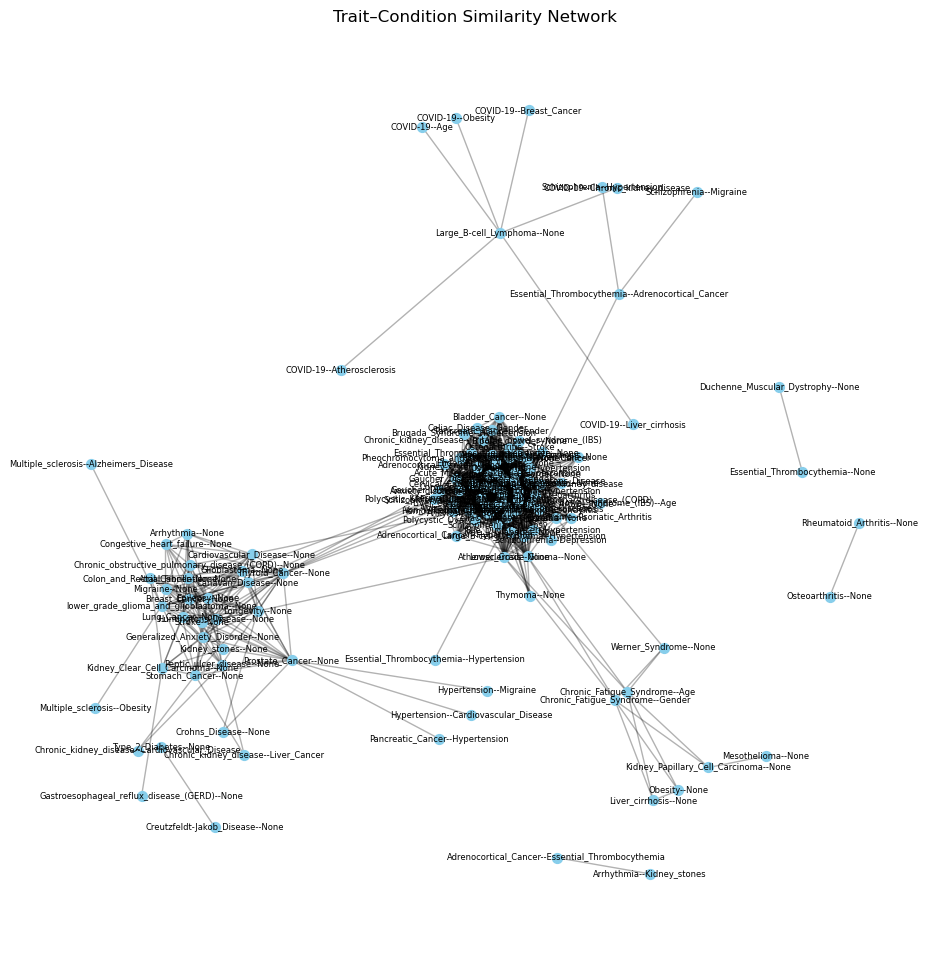

In [25]:
import matplotlib.pyplot as plt

# 使用 spring layout 排布节点
pos = nx.spring_layout(G, seed=42, k=0.3)

# 绘制图形
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='skyblue')
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=6)
plt.title("Trait–Condition Similarity Network")
plt.axis('off')
plt.show()


In [1]:
import json
import pandas as pd

json_path = "significant_pairs.json"
with open(json_path, "r") as f:
    data = json.load(f)

df = pd.DataFrame(data)

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

edge_weights = []
epsilon = 1e-10
for _, row in df.iterrows():
    p1, p2 = row["pair1"], row["pair2"]
    fdr = row["fdr_adj_pval"]
    weight = -np.log10(fdr + epsilon)
    edge_weights.append((p1, p2, weight, row["shared_genes"]))


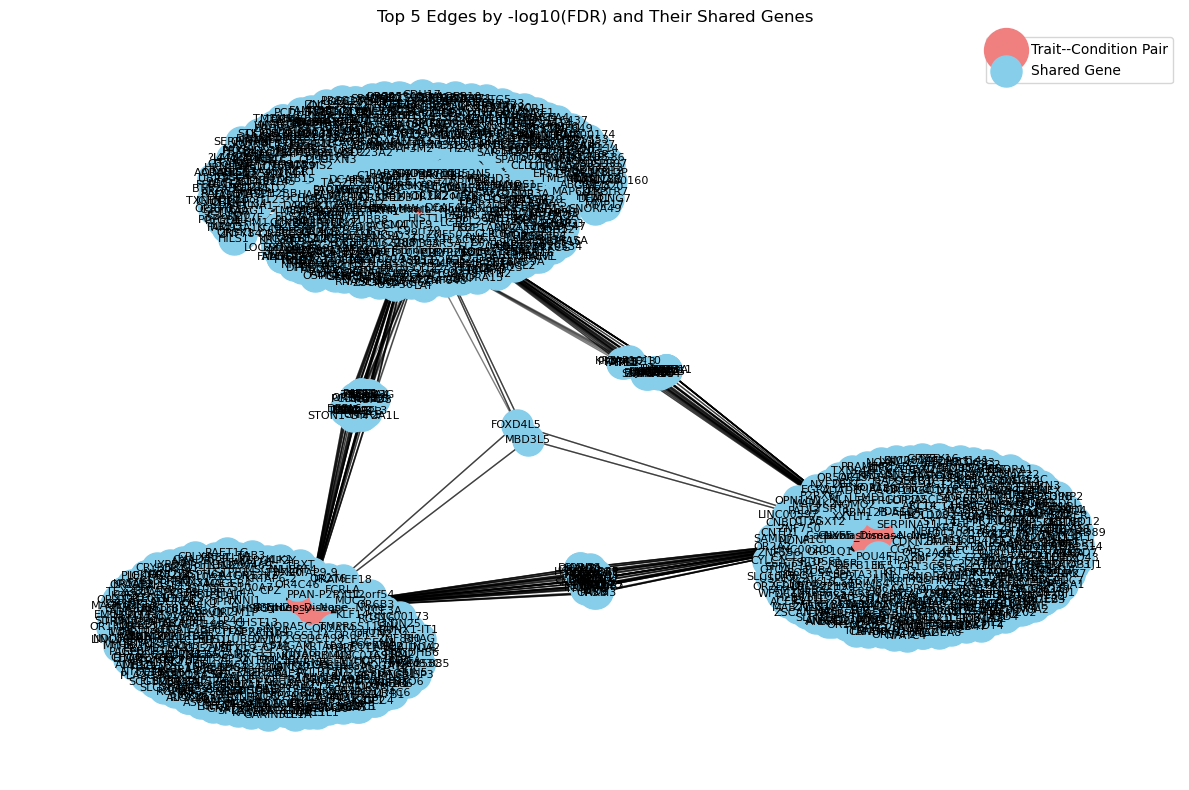

In [2]:
# Select top 5 edges by weight
top5_edges = sorted(edge_weights, key=lambda x: x[2], reverse=True)[:5]

# Collect nodes and genes involved in top 5 edges
top5_pairs = set()
connected_genes = set()
for p1, p2, _, genes in top5_edges:
    top5_pairs.update([p1, p2])
    connected_genes.update(genes)

# Build subgraph
top5_graph = nx.Graph()
top5_graph.add_nodes_from(top5_pairs, type='pair')
top5_graph.add_nodes_from(connected_genes, type='gene')

# Add edges from pairs to genes
for p1, p2, _, genes in top5_edges:
    for g in genes:
        top5_graph.add_edge(p1, g)
        top5_graph.add_edge(p2, g)

# Visualization
pos = nx.spring_layout(top5_graph, seed=42)
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(top5_graph, pos,
                       nodelist=[n for n in top5_graph if top5_graph.nodes[n]['type'] == 'pair'],
                       node_color='lightcoral', node_size=1000, label='Trait--Condition Pair')
nx.draw_networkx_nodes(top5_graph, pos,
                       nodelist=[n for n in top5_graph if top5_graph.nodes[n]['type'] == 'gene'],
                       node_color='skyblue', node_size=500, label='Shared Gene')
nx.draw_networkx_edges(top5_graph, pos, alpha=0.5)
nx.draw_networkx_labels(top5_graph, pos, font_size=8)
plt.title("Top 5 Edges by -log10(FDR) and Their Shared Genes")
plt.legend()
plt.axis('off')
plt.tight_layout()
plt.show()


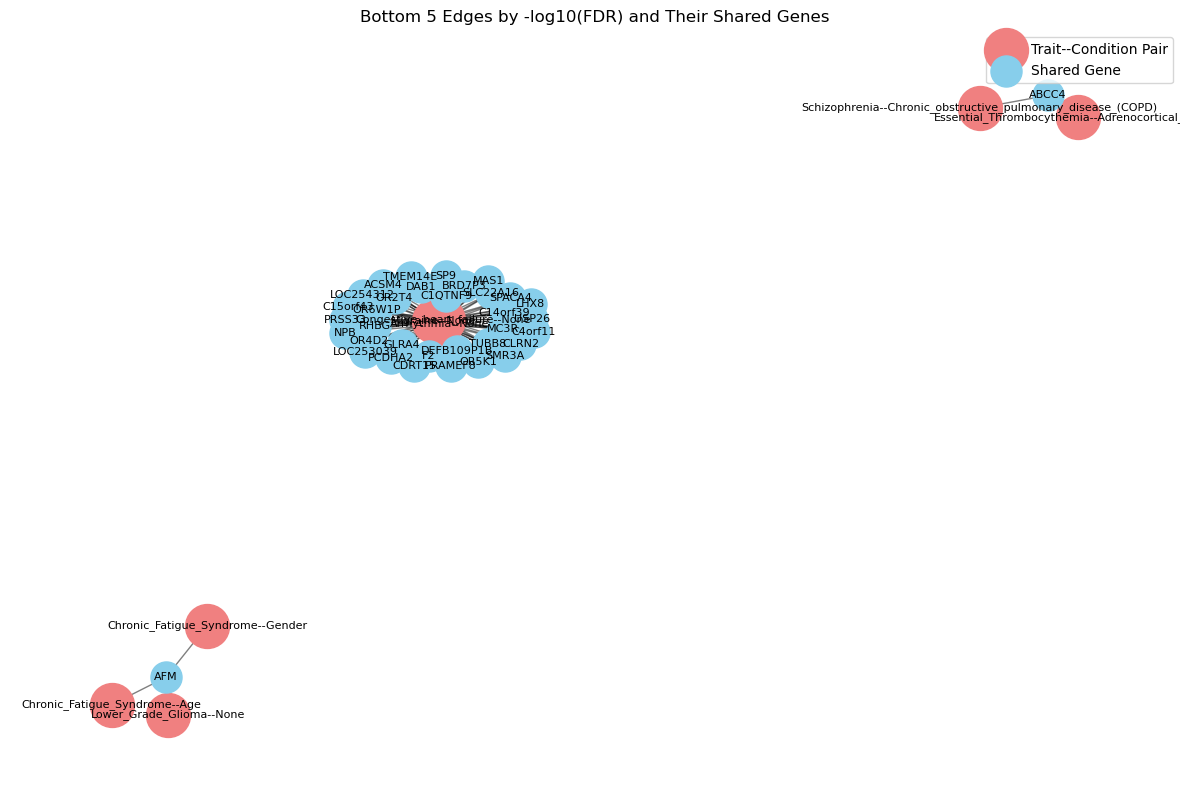

In [3]:
# Select bottom 5 edges by weight (least significant FDR, i.e., smallest -log10(FDR))
bottom5_edges = sorted(edge_weights, key=lambda x: x[2])[:5]

# Collect nodes and genes involved in bottom 5 edges
bottom5_pairs = set()
connected_genes_bottom = set()
for p1, p2, _, genes in bottom5_edges:
    bottom5_pairs.update([p1, p2])
    connected_genes_bottom.update(genes)

# Build subgraph
bottom5_graph = nx.Graph()
bottom5_graph.add_nodes_from(bottom5_pairs, type='pair')
bottom5_graph.add_nodes_from(connected_genes_bottom, type='gene')

# Add edges from pairs to genes
for p1, p2, _, genes in bottom5_edges:
    for g in genes:
        bottom5_graph.add_edge(p1, g)
        bottom5_graph.add_edge(p2, g)

# Visualization
pos = nx.spring_layout(bottom5_graph, seed=42)
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(bottom5_graph, pos,
                       nodelist=[n for n in bottom5_graph if bottom5_graph.nodes[n]['type'] == 'pair'],
                       node_color='lightcoral', node_size=1000, label='Trait--Condition Pair')
nx.draw_networkx_nodes(bottom5_graph, pos,
                       nodelist=[n for n in bottom5_graph if bottom5_graph.nodes[n]['type'] == 'gene'],
                       node_color='skyblue', node_size=500, label='Shared Gene')
nx.draw_networkx_edges(bottom5_graph, pos, alpha=0.5)
nx.draw_networkx_labels(bottom5_graph, pos, font_size=8)
plt.title("Bottom 5 Edges by -log10(FDR) and Their Shared Genes")
plt.legend()
plt.axis('off')
plt.tight_layout()
plt.show()


In [4]:
from collections import defaultdict
import pandas as pd

# Count number of unique trait--condition pairs connected to each gene
gene_to_pairs = defaultdict(set)

for _, row in df.iterrows():
    p1, p2 = row["pair1"], row["pair2"]
    for g in row["shared_genes"]:
        gene_to_pairs[g].add(p1)
        gene_to_pairs[g].add(p2)

# Convert to DataFrame
gene_pair_counts = pd.DataFrame([
    {"gene": g, "connected_pairs": len(pairs)}
    for g, pairs in gene_to_pairs.items()
])

# Sort by number of connected pairs (descending)
gene_pair_counts_sorted = gene_pair_counts.sort_values(by="connected_pairs", ascending=False).reset_index(drop=True)

gene_pair_counts_sorted

,gene,connected_pairs
0,A1CF,25
1,AAGAB,25
2,A2M,24
3,A1BG,23
4,AAAS,21
...,...,...
3109,SLCO1C1,2
3110,CYCSP52,2
3111,PARP6,2
3112,NLRP14,2


Total number of unique traits: 86


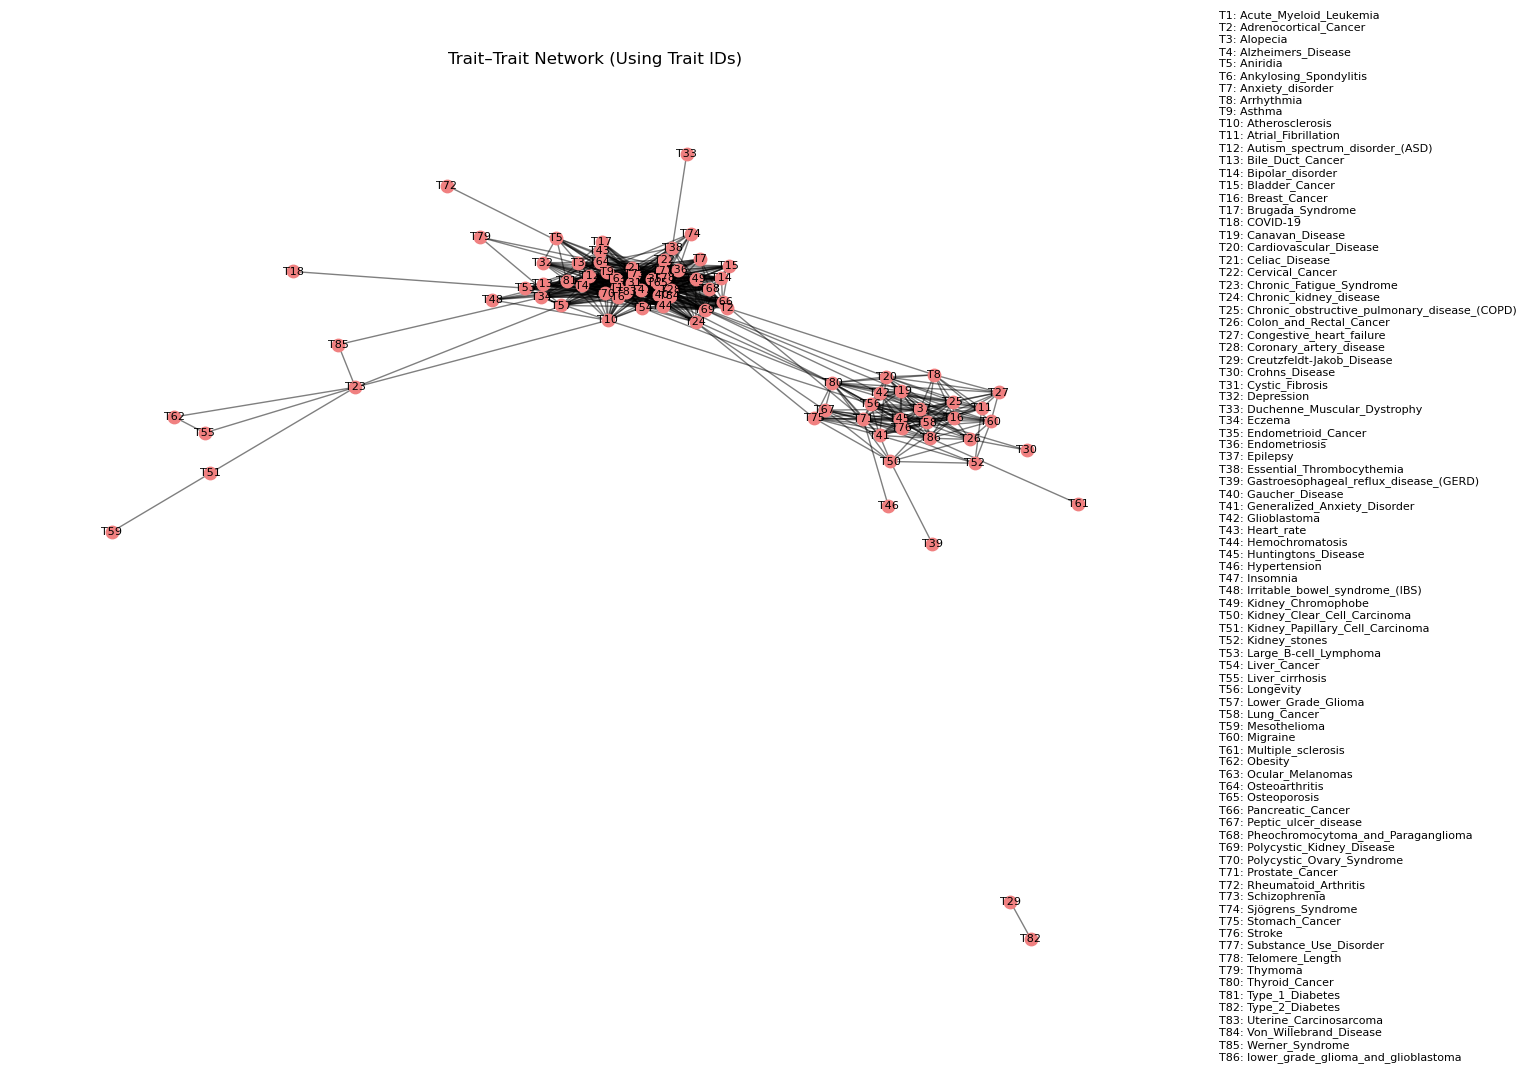

In [4]:
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 读取 JSON 数据
json_path = "significant_pairs.json"
with open(json_path, "r") as f:
    data = json.load(f)

df = pd.DataFrame(data)

# 构建 trait–trait 边
edges = []
for _, row in df.iterrows():
    trait1 = row["pair1"].split("--")[0]
    trait2 = row["pair2"].split("--")[0]
    
    if trait1 != trait2 and len(row["shared_genes"]) > 0:
        edges.append((trait1, trait2))

# 所有 trait 去重
all_traits = set()
for t1, t2 in edges:
    all_traits.add(t1)
    all_traits.add(t2)

# 打印 trait 数量
print(f"Total number of unique traits: {len(all_traits)}")

# 构建 trait 映射编号：Trait -> T1, T2, ...
trait_to_id = {trait: f"T{i+1}" for i, trait in enumerate(sorted(all_traits))}
id_to_trait = {v: k for k, v in trait_to_id.items()}

# 替换边为编号版本
edges_numbered = [(trait_to_id[t1], trait_to_id[t2]) for t1, t2 in edges]

# 构建图
G = nx.Graph()
G.add_edges_from(edges_numbered)

# 可视化
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_nodes(G, pos, node_color='lightcoral', node_size=80)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8)

# 添加 Legend
legend_elements = [f"{k}: {v}" for k, v in id_to_trait.items()]
legend_text = "\n".join(legend_elements)

plt.title("Trait–Trait Network (Using Trait IDs)")
plt.axis('off')

# 自定义 legend 显示在图外右边
plt.gcf().text(1.02, 0.5, legend_text, fontsize=8, va='center', ha='left')
plt.tight_layout()
plt.show()


In [8]:
def visualize_subgraph_by_traits(traits, G, trait_to_id, id_to_trait, title="Trait Subgraph View"):
    import matplotlib.pyplot as plt
    import networkx as nx

    # 将 trait 名转成编号
    trait_ids = [trait_to_id[t] for t in traits if t in trait_to_id]
    
    # 包含这些节点及其邻居
    sub_nodes = set(trait_ids)
    for t_id in trait_ids:
        sub_nodes.update(G.neighbors(t_id))
    
    # 构建子图
    subG = G.subgraph(sub_nodes).copy()

    # 颜色设置：input traits 为蓝色，其它为浅红色
    node_colors = []
    for node in subG.nodes():
        if node in trait_ids:
            node_colors.append('cornflowerblue')  # input 中的 trait
        else:
            node_colors.append('lightcoral')      # 邻居 trait

    # 绘图
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(subG, seed=42)

    nx.draw_networkx_nodes(subG, pos, node_color=node_colors, node_size=800)
    nx.draw_networkx_edges(subG, pos, alpha=0.5)
    nx.draw_networkx_labels(subG, pos, font_size=8)

    # 生成 legend
    legend_elements = [f"{node}: {id_to_trait[node]}" for node in subG.nodes()]
    legend_text = "\n".join(sorted(legend_elements))

    plt.title(title)
    plt.axis('off')
    plt.gcf().text(1.02, 0.5, legend_text, fontsize=8, va='center', ha='left')
    plt.tight_layout()
    plt.show()


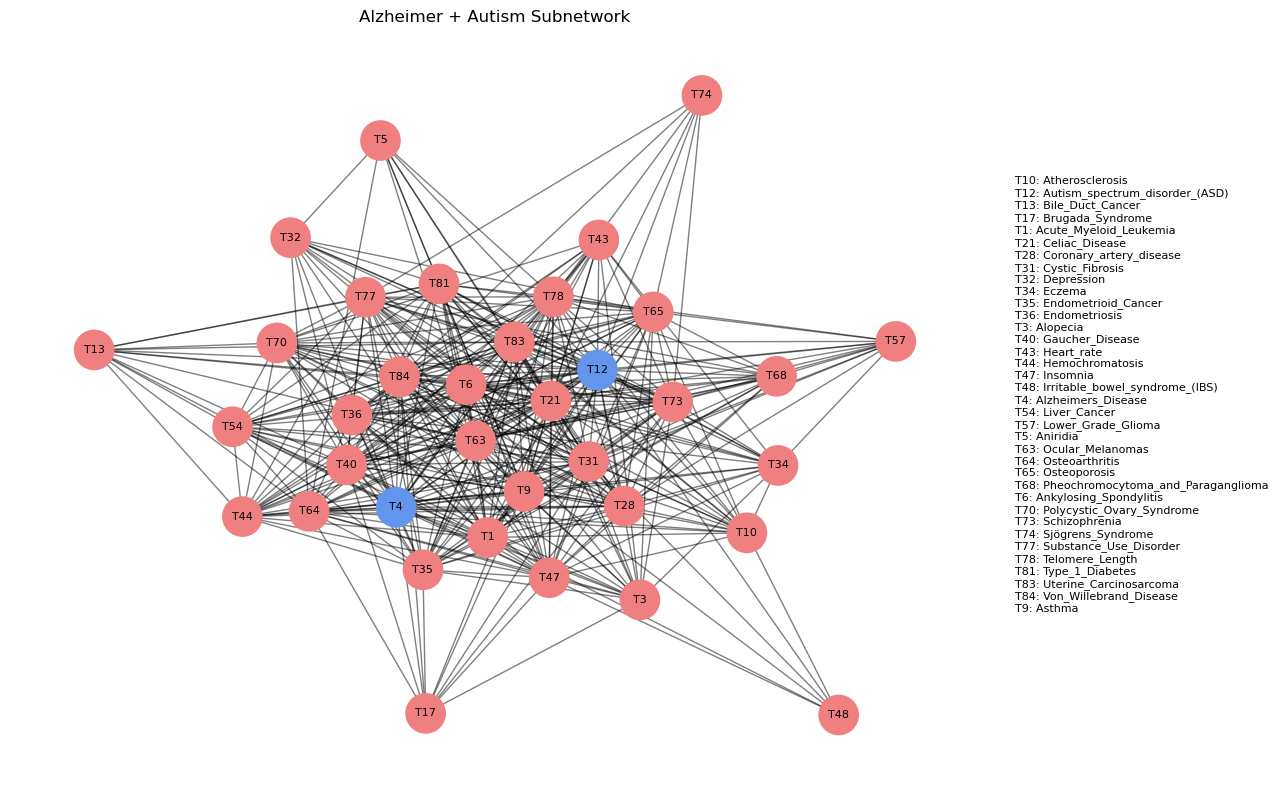

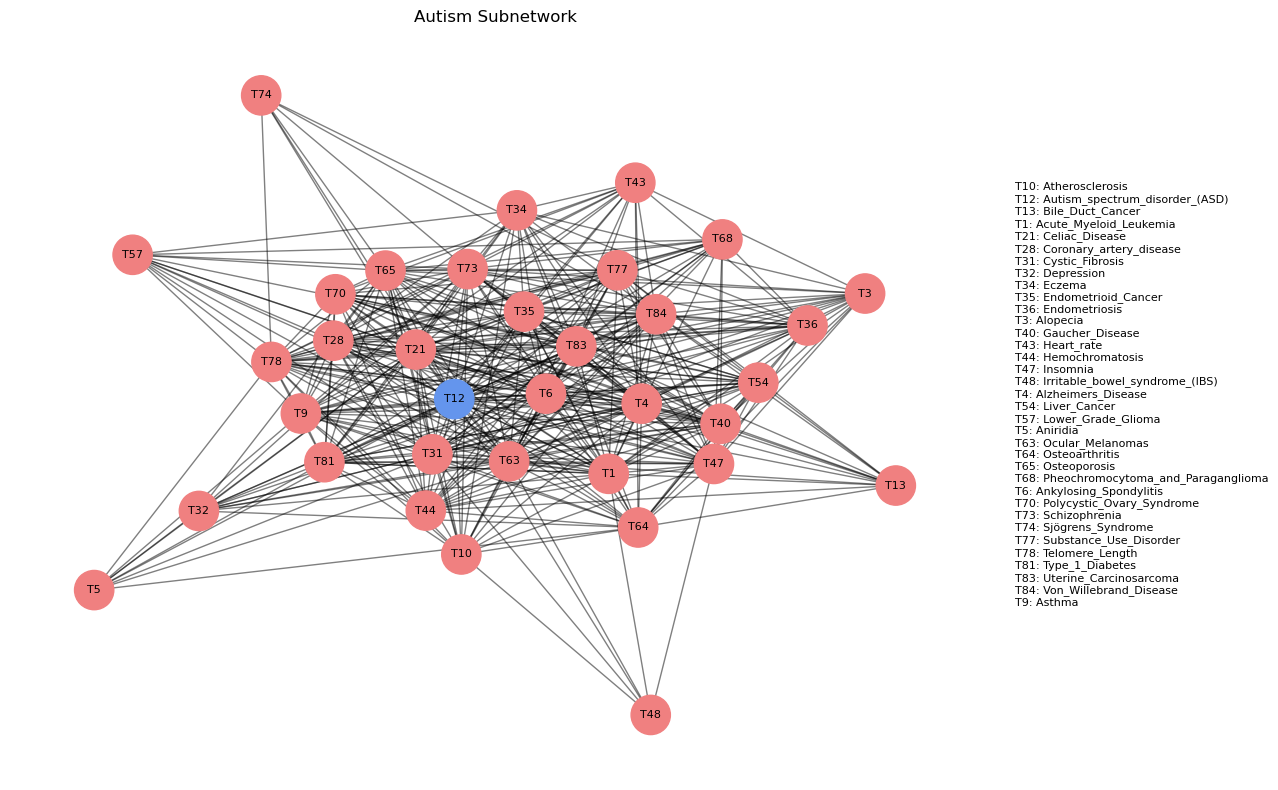

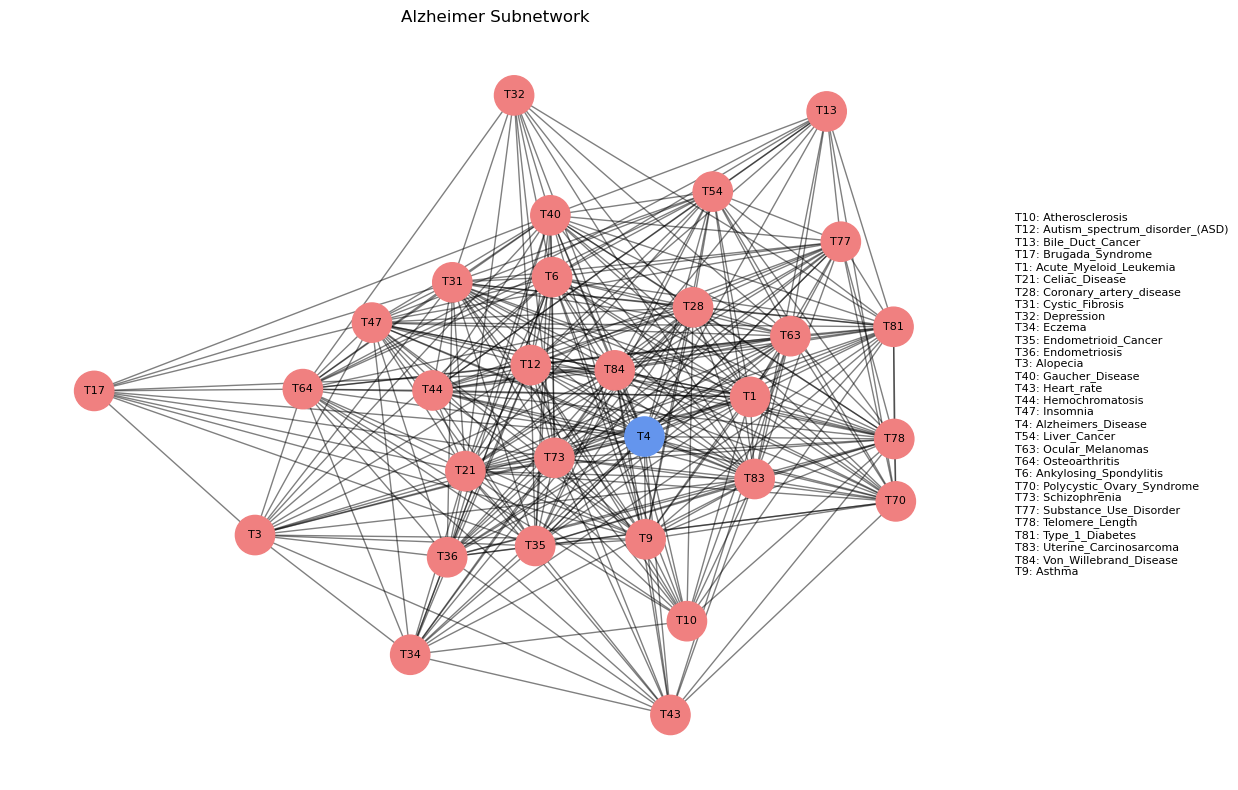

In [12]:
# 例子：只看 Alzheimer’s 和 Autism 相关的子图
target_traits = ["Alzheimers_Disease", "Autism_spectrum_disorder_(ASD)"]
visualize_subgraph_by_traits(target_traits, G, trait_to_id, id_to_trait, title="Alzheimer + Autism Subnetwork")

target_traits = ["Autism_spectrum_disorder_(ASD)"]
visualize_subgraph_by_traits(target_traits, G, trait_to_id, id_to_trait, title="Autism Subnetwork")

target_traits = ["Alzheimers_Disease"]
visualize_subgraph_by_traits(target_traits, G, trait_to_id, id_to_trait, title="Alzheimer Subnetwork")


# 结合Pathways进行分析

我对每一个pair中的基因都做了GO Enrichment Analysis, 找到了其中富集的pathways, 以及对应的significantly expressed genes是什么. 

另外, 我还将pairs两两组合成为一个combination, 来研究不同疾病之间的关系. 有一部分有shared genes并且通过了hypergeometric significance test. 我叫他们significant combination. 这样的pairs有1.3k.

我还对significant combinations中pair1和pair2的shared genes与pathways做了对比, 找到了有shared pathways的combination, 有179个. 并列出了所有的shared genes以及他们对应的shared pathways